# <center> Cajamar UniversityHack 2023

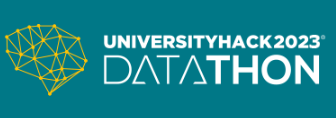
    
## Equipo: Malbecs
## Fase: I
## Centro: Universidad Complutense de Madrid
### Miembros: Trosman Denis, Stammati Vito, Kumar Sumit.

## <center> Reto Wine Prediction

## Importación de librerias

In [1]:
#EDA
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Modelos
import sklearn as sk

#Resultados
import shap

## Lectura de datos

- CAMPAÑA: Año de la campaña.
- ID_FINCA: Identificador de finca.
- ID_ZONA: Identificador de una zona con una tipología de suelo común
- ID_ESTACION: Identificador de estación meteorológica.
- ALTITUD: Altitud media de la finca sobre el nivel del mar en metros.
- VARIEDAD: Código de variedad de la uva que se cultiva en la finca.
- MODO: Código del modo de cultivo.
- TIPO: Tipo de cultivo dentro de la variedad.
- COLOR: Identificador del color de la uva.
- SUPERFICIE: Superficie en hectáreas que ocupa la finca.
- PRODUCCION: Producción en kg. Obtenida en la campaña.

UH_2023_TRAIN

In [2]:
df = pd.read_csv('C:/Users/denis/OneDrive/Escritorio/Datathon/datos/UH_2023_TRAIN.txt', sep= '|', header=0 )

In [3]:
df.head()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00


## Análisis exploratorio de datos

Observamos columnas y modificamos los nombres para que estén bajo buenas prácticas

In [4]:
df.columns

Index(['CAMPAÑA', 'ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'VARIEDAD',
       'MODO', 'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION'],
      dtype='object')

In [5]:
df.columns = [col.lower().replace('-','_') for col in df.columns]

**Relaciones entre variables id**

Cada finca tiene una sola zona y una sola estacion

In [7]:
df.groupby(['id_finca'])['id_zona'].nunique().value_counts()

1    1231
Name: id_zona, dtype: int64

In [8]:
df.groupby(['id_finca'])['id_estacion'].nunique().value_counts()

1    1231
Name: id_estacion, dtype: int64

Cada zona debe tener una estacion

In [9]:
df.groupby(['id_zona'])['id_estacion'].nunique().value_counts()

1    100
2     19
3      6
Name: id_estacion, dtype: int64

In [10]:
df.groupby(['variedad'])['tipo'].value_counts()

variedad  tipo
4         1         45
8         0         35
9         0        240
10        0          5
15        0        253
          1          6
17        0       2165
          1          2
23        0         74
26        0        143
          1          7
32        0        974
38        0          6
          1          2
40        0        401
43        0         57
48        0          4
52        0        583
          1         28
55        0         18
59        0       2755
          1         15
62        0         18
65        0         39
68        0        503
71        0         16
81        0        555
          1         13
84        0         54
87        0        431
92        0         62
94        0         92
Name: tipo, dtype: int64

**Características del dataset**

In [11]:
print(f'Número de filas: {df.shape[0]}, Número de columnas:{df.shape[1]}')
print(f'\nCantidad de duplicados: {df.duplicated().sum()}\n')
print('-------- Tipos de columnas --------')
print(df.dtypes)
print('\n -------- Cantidad de nulos --------')
df.isna().sum()

Número de filas: 9601, Número de columnas:11

Cantidad de duplicados: 0

-------- Tipos de columnas --------
campaña          int64
id_finca         int64
id_zona          int64
id_estacion      int64
altitud         object
variedad         int64
modo             int64
tipo             int64
color            int64
superficie     float64
produccion     float64
dtype: object

 -------- Cantidad de nulos --------


campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          54
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

In [12]:
df.groupby(['campaña','id_estacion','id_zona','id_finca']).agg({'id_estacion': ['count'], 'produccion': 'sum'})

id_estacion produccion
                                           count        sum
campaña id_estacion id_zona id_finca                       
14      0           672     22900              1   30860.00
        2           828     49672              1    4880.70
                    964     35465              1   13557.50
                            37826              2   66891.30
                    973     19515              1   18980.50
...                                          ...        ...
22      19          987     39040              1       0.00
                            64845              2       0.00
                            74410              1       0.00
                            76949              1       0.00
                            79903              1       0.00

[7482 rows x 2 columns]

Total producción por año asumiendo que no hay repetidos

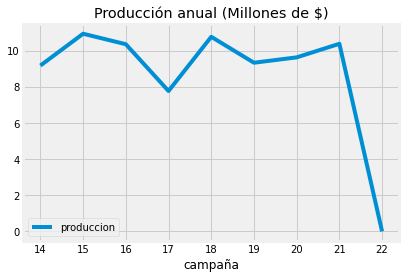

In [13]:
anuales = df.groupby(['campaña']).agg({'produccion': 'sum'})

anuales['produccion'] = anuales.produccion/1000000

anuales.plot(title='Producción anual (Millones de $)')
plt.show()

Vemos distribuciones y si hay valores mayoritarios

In [14]:
def valores_unicos(df,columna):
    data_frame = pd.DataFrame(df[columna].value_counts())
    data_frame['share']=data_frame[columna]/sum(data_frame[columna])*100 
    return data_frame

#Funcion para mostrar DataFrames lado por lado
#fuente: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

from IPython.display import display_html
from itertools import chain,cycle

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [15]:
for col in df.columns:
    display_side_by_side(valores_unicos(df,col).head(),
                         titles = [col])

,campaña,share
14,1148,11.96
15,1116,11.62
16,1079,11.24
22,1075,11.20
18,1061,11.05


,id_finca,share
4024,59,0.61
49636,54,0.56
48827,47,0.49
84174,46,0.48
61177,36,0.37


,id_zona,share
441,703,7.32
272,419,4.36
134,406,4.23
464,378,3.94
510,283,2.95


,id_estacion,share
12,2060,21.46
5,1155,12.03
7,1113,11.59
16,1087,11.32
15,956,9.96


,altitud,share
455-470,703,7.36
650-660,680,7.12
455-465,431,4.51
630-640,430,4.50
600-670,419,4.39


,variedad,share
59,2770,28.85
17,2167,22.57
32,974,10.14
52,611,6.36
81,568,5.92


,modo,share
2,4891,50.94
1,4710,49.06


,tipo,share
0,9483,98.77
1,118,1.23


,color,share
1,8097,84.33
0,1504,15.67


,superficie,share
0.00,6518,67.89
1.85,14,0.15
2.11,12,0.12
0.78,12,0.12
0.43,11,0.11


,produccion,share
2260.00,10,0.12
2950.00,10,0.12
3520.00,9,0.11
1970.00,9,0.11
2670.00,9,0.11


**Distribuciones y descripción general**

- Altidud transformar 
- ids, variedades, modo, tipo y color pasar a categoricas

In [16]:
#Númericas
df.describe()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,superficie,produccion
count,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,8526.00
mean,17.94,50818.24,498.50,12.16,45.49,1.51,0.01,0.84,0.70,9209.19
std,2.61,29016.57,261.43,4.76,23.81,0.50,0.11,0.36,1.79,13268.81
min,14.00,200.00,7.00,0.00,4.00,1.00,0.00,0.00,0.00,0.72
25%,16.00,25104.00,284.00,7.00,17.00,1.00,0.00,1.00,0.00,1940.00
50%,18.00,50946.00,464.00,12.00,52.00,2.00,0.00,1.00,0.00,4620.00
75%,20.00,76361.00,726.00,16.00,59.00,2.00,0.00,1.00,0.56,11137.50
max,22.00,99793.00,990.00,19.00,94.00,2.00,1.00,1.00,26.85,177520.00


In [17]:
#Resto
df.describe(include='O')

,altitud
count,9547
unique,84
top,455-470
freq,703


Transformación de altitud a numerica

In [18]:
def transform_altitud(alt):
    if type(alt) is str:
        alt_list = alt.split("-")
        alt_list = list(map(float, alt_list))
        return np.mean(alt_list) 
    return alt

In [20]:
df['altitud'] = df['altitud'].apply(lambda alt: transform_altitud(alt))

In [23]:
df.head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
0,14,76953,515,4,660.00,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660.00,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520.00,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520.00,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00


In [24]:
df.nunique(axis=0)

campaña           9
id_finca       1231
id_zona         125
id_estacion      20
altitud          57
variedad         25
modo              2
tipo              2
color             2
superficie     1212
produccion     6287
dtype: int64

In [ ]:
# df['prod_x_sup'] = [y/x if x > 0 else 0 for x,y in zip(df.superficie,df.produccion)]

Desvío estandar

In [25]:
(df.groupby(['id_finca']).
 agg({'id_finca': ['count'], 'produccion': 'std'}).
 droplevel(1,axis=1).
 sort_values('produccion',ascending=False))

,id_finca,produccion
id_finca,,
84804,19,56908.84
49636,54,50006.77
16864,12,35455.92
76459,24,33635.69
86582,19,32710.19
...,...,...
98731,1,NaN
98808,1,NaN
98825,2,NaN


Cantidad de estaciones por año

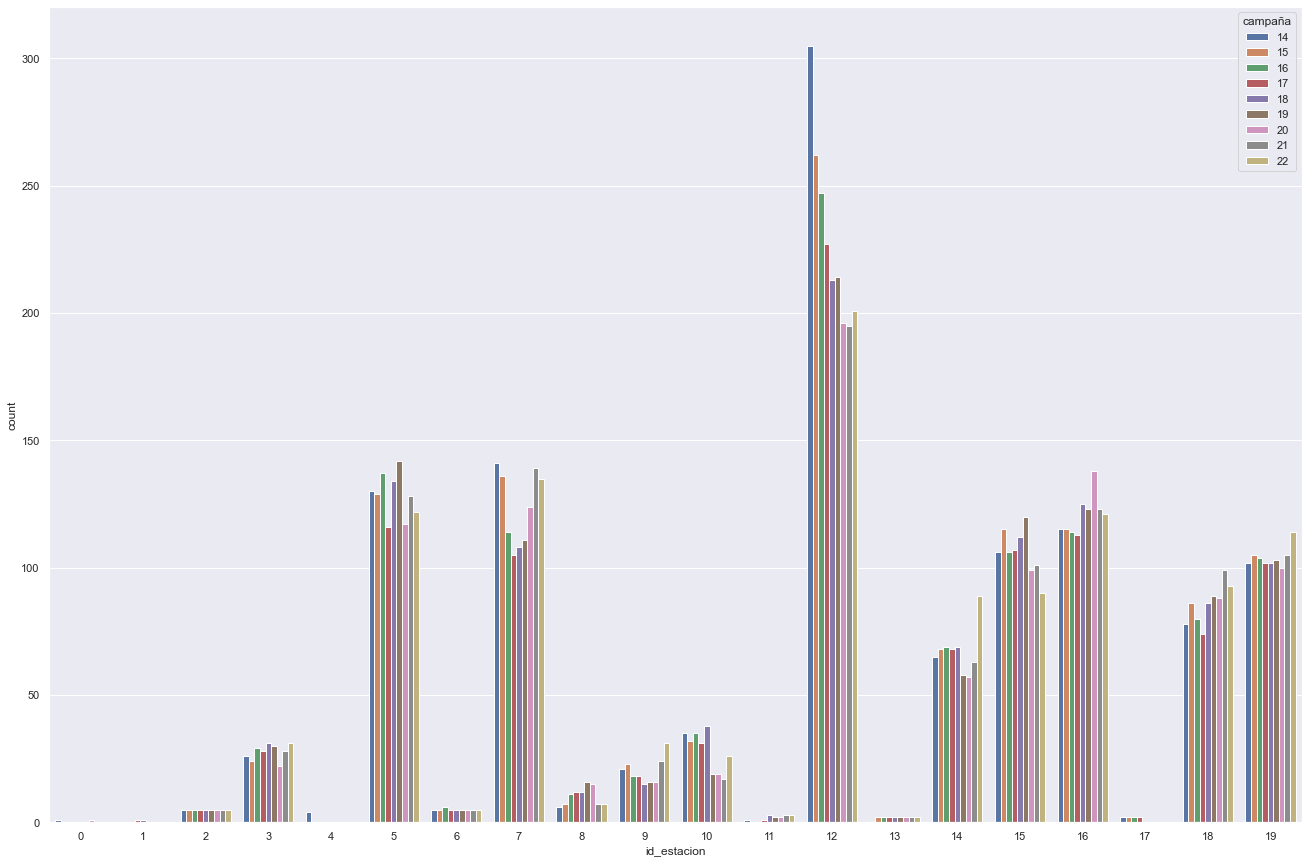

In [27]:
sns.set(rc = {'figure.figsize':(20,15)})
sns.countplot(data=df, x='id_estacion',hue='campaña')
plt.show()

### Data a predecir

In [ ]:
test = df[df.campaña==22]
print(f'Dimensiones test {test.shape}')
print(f'Cantidad de nulos produccion: {test.produccion.isna().sum()}')

In [ ]:
test.head(10)

In [ ]:
test = test.sort_values(['campaña','id_finca','id_zona','id_estacion','variedad'])

In [ ]:
print(f'Cantida de duplicados por totalidad de filas: {test.duplicated().sum()}')
print(f"Cantida de duplicados por ids: {test.duplicated(subset=['campaña','id_finca','id_zona','id_estacion']).sum()}")
print(f"Cantida de duplicados por ids + variedad: {test.duplicated(subset=['campaña','id_finca','id_zona','id_estacion','variedad']).sum()}")
print(f"Cantida de duplicados por ids + variedad + modo: {test.duplicated(subset=['campaña','id_finca','id_zona','id_estacion','variedad','modo']).sum()}")

### Preparacion para modelo

**FillNAs**

In [28]:
df.isna().sum()

campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          54
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

In [29]:
df['superficie'] = df['superficie'].replace(0, np.nan)

In [30]:
df['superficie'].isna().sum()

6518

Filleamos NA segun la media por estacion

In [32]:
for col in ['superficie','altitud']:
    df[col]  = df.groupby(['id_estacion'])[col].transform(lambda x: x.fillna(x.mean()))

In [34]:
df.isna().sum() #Tenemos NAs en superficie, puede darse porque no encontró la estación para calcularle la mean. Imputamos de nuevo

campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud           0
variedad          0
modo              0
tipo              0
color             0
superficie       14
produccion     1075
dtype: int64

In [36]:
df['superficie']  = df['superficie'].fillna(df['superficie'].mean())

In [37]:
df['superficie'].isna().sum()

0

**Encoder para las categoricas**

In [38]:
cat_cols = ['id_finca', 'id_zona', 'id_estacion','variedad','modo','tipo','color']

In [42]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for var in cat_cols:
    df[var] = label_encoder.fit_transform(df[var])

df.head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
0,14,936,68,4,660.00,7,1,0,1,2.15,22215.00
1,14,1021,68,4,660.00,7,1,0,1,2.15,22215.00
2,14,1042,40,4,520.00,8,1,0,1,2.15,20978.00
3,14,838,40,4,520.00,8,1,0,1,2.15,40722.00
4,14,175,108,14,659.10,20,0,0,1,3.51,14126.00


**Númericas**

In [44]:
cont_vars = ['superficie', 'produccion', 'altitud']

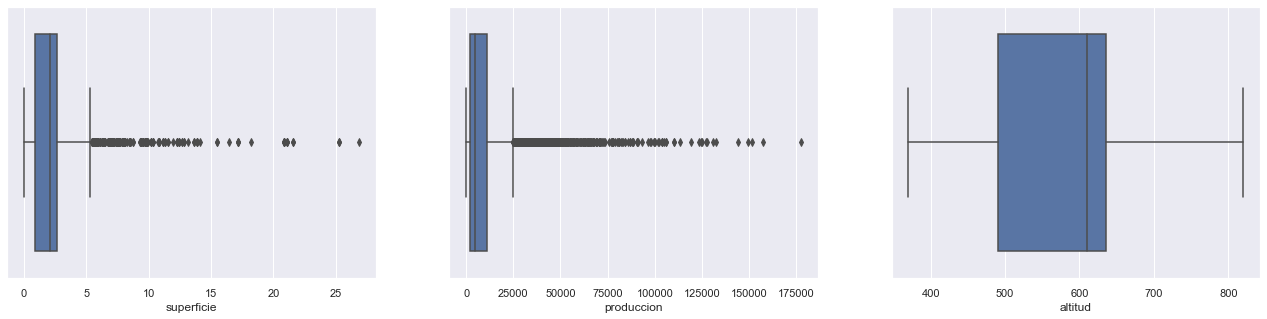

In [46]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.boxplot(x=df[df['superficie']>0]['superficie'], ax=axes[0])
sns.boxplot(x=df['produccion'], ax=axes[1])
sns.boxplot(x=df['altitud'], ax=axes[2])
plt.show()

## Modelo dummy

In [47]:
train_df = df[df.campaña<22]

In [48]:
train_df.shape

(8526, 11)

In [50]:
train_df.head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
0,14,936,68,4,660.00,7,1,0,1,2.15,22215.00
1,14,1021,68,4,660.00,7,1,0,1,2.15,22215.00
2,14,1042,40,4,520.00,8,1,0,1,2.15,20978.00
3,14,838,40,4,520.00,8,1,0,1,2.15,40722.00
4,14,175,108,14,659.10,20,0,0,1,3.51,14126.00


In [51]:
train_df.isna().sum()

campaña        0
id_finca       0
id_zona        0
id_estacion    0
altitud        0
variedad       0
modo           0
tipo           0
color          0
superficie     0
produccion     0
dtype: int64

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [53]:
#Split

import sklearn as sk
from sklearn.model_selection import train_test_split

target = 'produccion'

X = train_df.loc[:, train_df.columns != target]
y = train_df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=99)

In [54]:
model = RandomForestRegressor()

kfold = KFold(n_splits=10,shuffle=True,random_state=99)

result = cross_val_score(estimator=model,
                         X=X,
                         y=y,
                         cv=kfold,
                         scoring = 'neg_mean_squared_error')

In [55]:
np.mean(np.sqrt(np.abs(result)))

6303.830111334528

Feature importances

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=99)

rf = RandomForestRegressor(random_state=99)

rf.fit(X_train, y_train)

RandomForestRegressor(random_state=99)

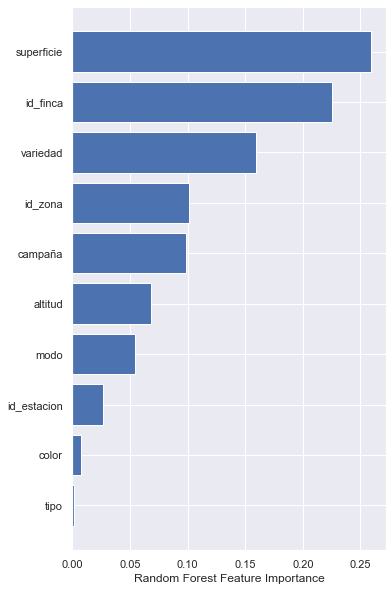

In [78]:
plt.figure(figsize=(5,10))

sorted_idx = rf.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [77]:
from sklearn.metrics import mean_squared_error

# Predict on test data

prediction = rf.predict(X_test)
# Compute mean squared error
mse = mean_squared_error(y_test, prediction)
# Print results
print(np.sqrt(mse))

6409.976720641327


### Modelo 2

- Volar 'id_finca', 'id_zona', y nos quedamos con estacion nomas para joinear.
- "Tipo" y 'color' estan muy desbalanceada, volar si no suma al modelo.

In [83]:
for col in ['tipo','color','modo']:
    print(df[col].value_counts())

0    9483
1     118
Name: tipo, dtype: int64
1    8097
0    1504
Name: color, dtype: int64
1    4891
0    4710
Name: modo, dtype: int64


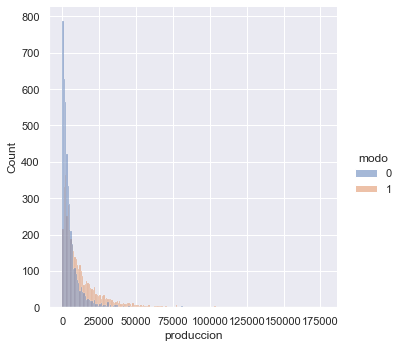

In [79]:
sns.displot(data=df,x='produccion',hue='modo')

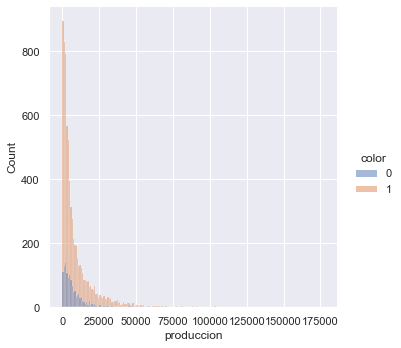

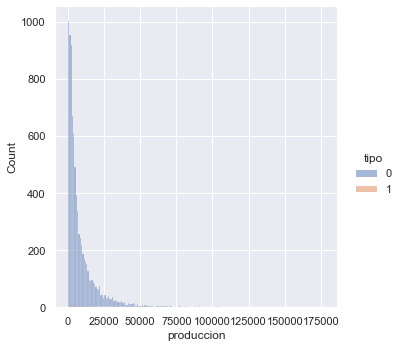

In [71]:
sns.displot(data=df,x='produccion',hue='color')
sns.displot(data=df,x='produccion',hue='tipo')

In [88]:
df2 = df.drop(columns=['id_finca','tipo','color'])

In [89]:
train_df = df2[df2.campaña<22]

target = 'produccion'

X = train_df.loc[:, train_df.columns != target]
y = train_df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=99)

rf = RandomForestRegressor(random_state=99)

rf.fit(X_train, y_train)

prediction = rf.predict(X_test)
# Compute mean squared error
mse = mean_squared_error(y_test, prediction)
# Print results
print(np.sqrt(mse))

10401.889955475714


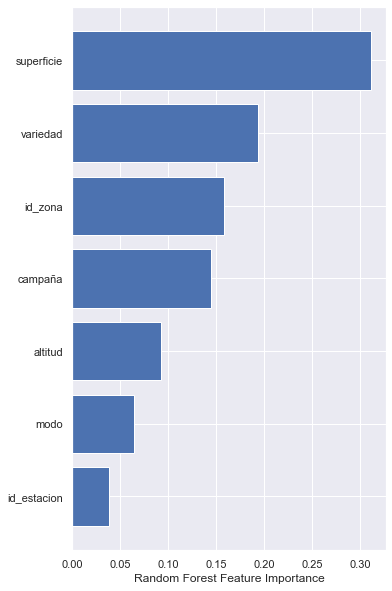

In [90]:
plt.figure(figsize=(5,10))

sorted_idx = rf.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

### Modelo 3 

- Join con ETO
- Volver a poner finca y/o zona

In [106]:
eto = pd.read_csv("C:/Users/denis/OneDrive/Escritorio/Datathon/datathon-cajamar-malbecs/data/processed/eto_processed.csv", index_col=0)

In [107]:
eto.head()

,ID_ESTACION,GustLocalDayAvg_1,GustLocalDayAvg_2,GustLocalDayAvg_3,GustLocalDayAvg_4,GustLocalDayAvg_5,GustLocalDayAvg_6,MSLPLocalDayAvg_1,MSLPLocalDayAvg_2,MSLPLocalDayAvg_3,MSLPLocalDayAvg_4,MSLPLocalDayAvg_5,MSLPLocalDayAvg_6,RelativeHumidityLocalDayAvg_1,RelativeHumidityLocalDayAvg_2,RelativeHumidityLocalDayAvg_3,RelativeHumidityLocalDayAvg_4,RelativeHumidityLocalDayAvg_5,RelativeHumidityLocalDayAvg_6,UVIndexLocalDayAvg_1,UVIndexLocalDayAvg_2,UVIndexLocalDayAvg_3,UVIndexLocalDayAvg_4,UVIndexLocalDayAvg_5,UVIndexLocalDayAvg_6,VisibilityLocalDayAvg_1,VisibilityLocalDayAvg_2,VisibilityLocalDayAvg_3,VisibilityLocalDayAvg_4,VisibilityLocalDayAvg_5,VisibilityLocalDayAvg_6,WindSpeedLocalDayAvg_1,WindSpeedLocalDayAvg_2,WindSpeedLocalDayAvg_3,WindSpeedLocalDayAvg_4,WindSpeedLocalDayAvg_5,WindSpeedLocalDayAvg_6,lluvia_daytime_avg_1,lluvia_daytime_avg_2,lluvia_daytime_avg_3,lluvia_daytime_avg_4,lluvia_daytime_avg_5,lluvia_daytime_avg_6,lluvia_night_avg_1,lluvia_night_avg_2,lluvia_night_avg_3,lluvia_night_avg_4,lluvia_night_avg_5,lluvia_night_avg_6,nieve_daytime_Avg_1,nieve_daytime_Avg_2,nieve_daytime_Avg_3,nieve_daytime_Avg_4,nieve_daytime_Avg_5,nieve_daytime_Avg_6,nieve_night_Avg_1,nieve_night_Avg_2,nieve_night_Avg_3,nieve_night_Avg_4,nieve_night_Avg_5,nieve_night_Avg_6,campaña
0,0,8.73,8.81,8.41,8.09,8.11,5.90,102201.83,102146.62,101755.81,101428.21,101617.30,101532.45,67.64,66.56,68.41,70.65,61.86,42.60,0.40,0.62,1.04,1.54,2.13,1.45,12703.95,12566.77,12205.02,12427.89,13459.72,16093.00,2.80,2.68,3.10,2.66,2.34,3.35,40.80,12.51,55.03,45.26,20.23,0.00,33.60,9.94,41.66,54.51,11.83,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,15
1,1,9.46,8.96,8.78,8.50,8.58,6.25,102234.06,102167.03,101762.08,101431.50,101629.07,101553.19,72.75,69.21,69.56,70.14,59.82,36.65,0.40,0.63,1.04,1.55,2.14,1.60,12317.72,12307.27,12143.72,12397.98,13268.26,16093.00,3.81,3.63,4.09,3.53,3.13,3.85,25.54,11.31,42.86,44.23,23.66,0.00,16.63,10.11,35.83,51.94,24.51,0.00,0.06,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,15
2,2,9.01,8.94,8.49,8.27,8.05,0.00,102230.35,102165.75,101763.44,101439.95,101615.43,101532.84,69.86,66.95,67.13,68.15,59.89,41.05,0.42,0.64,1.07,1.58,2.17,1.50,12708.40,12722.14,12670.05,12872.93,13692.44,16093.00,2.97,2.84,3.23,2.88,2.62,3.35,20.74,5.14,43.03,38.91,14.06,0.00,19.20,3.43,31.20,46.11,17.66,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15
3,3,9.29,9.06,8.66,8.48,8.16,6.30,102213.03,102157.90,101758.68,101429.61,101625.83,101547.07,71.02,69.21,70.03,71.44,62.10,38.90,0.40,0.62,1.04,1.54,2.14,1.50,12500.75,12391.16,12075.28,12384.46,13293.40,16093.00,3.61,3.43,3.89,3.33,2.91,3.65,31.54,8.74,44.74,35.49,16.97,0.00,25.89,8.23,38.06,43.03,16.11,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,15
4,4,9.37,9.01,8.65,8.43,8.25,6.00,102229.53,102164.91,101770.68,101446.43,101620.98,101541.87,70.35,67.81,68.13,68.75,59.33,37.10,0.41,0.63,1.06,1.56,2.15,1.50,12605.38,12518.67,12333.94,12669.56,13506.27,16093.00,3.79,3.57,4.05,3.50,3.06,3.85,22.80,7.54,45.26,37.37,12.00,0.00,18.51,8.91,37.54,43.54,23.83,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,15


In [108]:
eto.columns = [col.lower().replace('-','_') for col in eto.columns]

In [109]:
eto.shape

(160, 62)

In [110]:
df.id_estacion.value_counts().sort_index()

0        2
1        2
2       45
3      249
4        4
5     1155
6       46
7     1113
8       93
9      182
10     252
11      15
12    2060
13      16
14     606
15     956
16    1087
17       8
18     773
19     937
Name: id_estacion, dtype: int64

In [111]:
eto.id_estacion.value_counts().sort_index()

0     8
1     8
2     8
3     8
4     8
5     8
6     8
7     8
8     8
9     8
10    8
11    8
12    8
13    8
14    8
15    8
16    8
17    8
18    8
19    8
Name: id_estacion, dtype: int64

In [113]:
df_join = pd.merge(df, eto, on=['id_estacion', 'campaña'])

In [116]:
train_df = df_join[df_join.campaña<22]

target = 'produccion'

X = train_df.loc[:, train_df.columns != target]
y = train_df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=99)

rf = RandomForestRegressor(random_state=99)

rf.fit(X_train, y_train)

prediction = rf.predict(X_test)
# Compute mean squared error
mse = mean_squared_error(y_test, prediction)
# Print results
print(np.sqrt(mse))

8612.57328331649


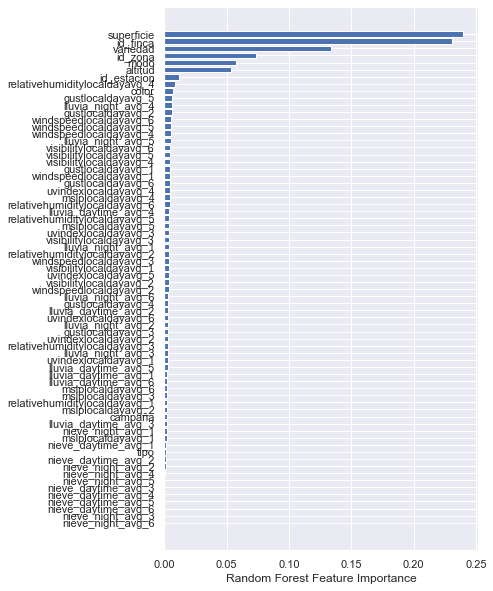

In [117]:
plt.figure(figsize=(5,10))

sorted_idx = rf.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()